In [1]:
import os
import numpy as np
import pandas as pd
import json
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import MaxAbsScaler
from sklearn.model_selection import LeaveOneOut

from library.utils import *
from library.model import *
from library.outlier import *
from library.active_learning import *

## Input: only modify here

- Data_folder: path to folder contains all experiment data, files must be csv, with row as experiment, each column contains concentration. NOTE: please name file with active learning round number, ex: plate_AL_1, plate_AL_2...
- Target: columns names which will not included in input X for modelling
- Name_list : column names of each repetition measurement
- Parameter file: path and file name must be csv, with each component as row, names in first column, then maximun concentration and different ratio in each column


- Flatten: True if using all repetitions for fitting, False if using their mean 
- Seed: a random number for reproductivity of new random experiment generated, please change each round
- Nb_new_data_predict : number of random experiment generated, without repeat with exited experiments
- Nb_new_data : number of new experiments suggest for next round


- Theta: parameter to control ratio of exploitation/exploration, only concern if using ucb as acquisation function
- Save_name: path and file names for result files

In [2]:
data_folder = "mahnaz"
target = ['Replicate 1','Replicate 2','Replicate 3']
name_list = ['Replicate 1','Replicate 2','Replicate 3']
parameter_file = "mahnaz\\param\\param.csv"

nb_rep = 100
flatten = True
seed = 59
nb_new_data_predict = 1000
nb_new_data = 50

statergy = 'ucb'
theta = 1 # for ucb formular
save_name = 'mahnaz\\new_exp\\round1.csv'

Read parameter file:
- check if component names are correct 
- verbose = False if you don't want to print out any information
- Poolsize is number of all possible combination/ experiments based on provided condition list
- Searching ratio is percentage of new data seen in active learning compare to poolsize

In [4]:
element_list, element_max, sampling_condition = import_parameter(parameter_file, nb_new_data_predict, sep = ',',verbose = True)

Number of metabolites : 36
Number of combinations - poolsize : 14551915228366851806640625
Searching ratio : 0.0 %
Possible concentrations: 


,AlaRS,ArgRS,AsnRS,AspRS,CysRS,GlnRS,GluRS,GlyRS,HisRS,IleRS,...,RF1,RF2,RF3,RRF,MTF,CK,MK,NDK,Ppiase,T7RNAP
0,143.333333,6.182380,83.650190,24.279211,4.597701,11.968504,46.840149,17.204301,3.404255,75.743049,...,49.382716,48.543689,33.557047,97.087379,58.479532,21.563342,27.649770,14.193548,6.191950,20.222447
1,286.666667,12.364760,167.300380,48.558422,9.195402,23.937008,93.680297,34.408602,6.808511,151.486098,...,98.765432,97.087379,67.114094,194.174757,116.959064,43.126685,55.299539,28.387097,12.383901,40.444894
2,430.000000,18.547141,250.950570,72.837633,13.793103,35.905512,140.520446,51.612903,10.212766,227.229147,...,148.148148,145.631068,100.671141,291.262136,175.438596,64.690027,82.949309,42.580645,18.575851,60.667341
3,573.333333,24.729521,334.600760,97.116844,18.390805,47.874016,187.360595,68.817204,13.617021,302.972196,...,197.530864,194.174757,134.228188,388.349515,233.918129,86.253369,110.599078,56.774194,24.767802,80.889788
4,716.666667,30.911901,418.250951,121.396055,22.988506,59.842520,234.200743,86.021505,17.021277,378.715244,...,246.913580,242.718447,167.785235,485.436893,292.397661,107.816712,138.248848,70.967742,30.959752,101.112235


Read all csv file in data folder, check if their column names and orders are the same, if not then skip file
 - Please check if all files you want appeared (using verbose = True)
 - if print out "All files have consistent column orders" => good to go

In [6]:
data, size_list = import_data(data_folder, verbose = True)
check_column_names(data,target,element_list)

Read  1  files: 
-  first_devided_by_standard.csv


,AlaRS,ArgRS,AsnRS,AspRS,CysRS,GlnRS,GluRS,GlyRS,HisRS,IleRS,...,RRF,MTF,CK,MK,NDK,Ppiase,T7RNAP,Replicate 1,Replicate 2,Replicate 3
0,573.33,6.18,334.60,48.56,22.99,59.84,46.84,68.82,13.62,227.23,...,388.35,233.92,107.82,27.65,70.97,24.77,101.11,-1.654233,6.361675,6.280490
1,716.67,30.91,334.60,121.40,13.79,11.97,46.84,34.41,17.02,75.74,...,485.44,116.96,86.25,138.25,56.77,12.38,20.22,1.264034,5.824099,6.486195
2,143.33,30.91,334.60,24.28,18.39,59.84,140.52,51.61,13.62,227.23,...,485.44,175.44,86.25,138.25,28.39,6.19,80.89,-2.543975,6.376486,5.233315
3,573.33,18.55,83.65,48.56,22.99,11.97,234.20,51.61,3.40,302.97,...,388.35,116.96,21.56,27.65,14.19,6.19,40.44,-3.123789,6.216310,7.804900
4,286.67,6.18,83.65,97.12,22.99,35.91,46.84,34.41,6.81,151.49,...,97.09,233.92,21.56,110.60,14.19,12.38,20.22,5.769793,5.495520,5.578899
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,716.67,18.55,418.25,48.56,9.20,35.91,93.68,68.82,17.02,378.72,...,388.35,292.40,21.56,27.65,28.39,24.77,60.67,5.465899,9.070397,4.389102
97,430.00,24.73,83.65,48.56,18.39,47.87,187.36,34.41,17.02,151.49,...,388.35,175.44,107.82,110.60,70.97,18.58,80.89,4.351801,6.477967,7.959590
98,143.33,6.18,250.95,121.40,22.99,47.87,234.20,86.02,17.02,151.49,...,97.09,292.40,43.13,82.95,56.77,30.96,40.44,2.802706,5.983726,-3.614738
99,430.00,18.55,167.30,72.84,22.99,47.87,93.68,34.41,10.21,302.97,...,291.26,233.92,107.82,110.60,70.97,18.58,101.11,2.206436,5.080271,3.810386


All files have consistent column orders.
All column names matched!


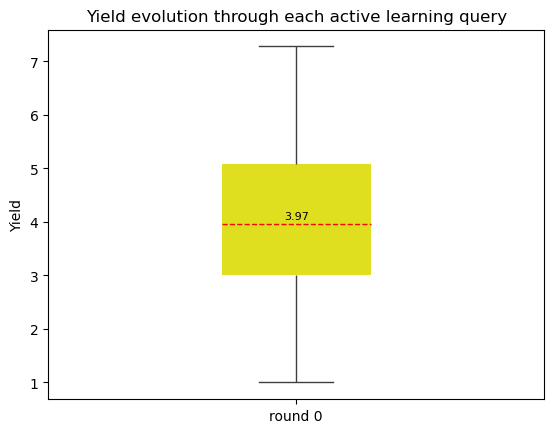

In [7]:
no_element = len(element_list)
y = np.array(data[name_list])
y_mean = np.mean(y, axis = 1)
X = data.iloc[:,0:no_element]
plot_each_round(y_mean,size_list)

## Modelling

- Normalized X by deviding with each columns maximum
- Using grid-search and 5 folds cross validation to find best kernel for gaussian process, training on ALL data
- Measure the best parameter performance by evaluate on different testing subset

In [8]:
X_train, X_test, y_train, y_test = split_and_flatten(X, y, ratio = 0, flatten = flatten)

scaler = MaxAbsScaler()
X_train_norm = scaler.fit_transform(X_train)

model = BayersianModels(n_folds= 10, model_type = 'gp')
#model = BayersianModels(n_folds= 5, model_type = 'gp')

model.train(X_train_norm, y_train)
y_pred_train, std_pred_train = model.predict(X_train_norm) 

Best hyperparameter found: {'kernel': RBF(length_scale=1) + 1**2 + WhiteKernel(noise_level=1)}


Text(0.5, 1.0, 'Histogram of R2 for different testing subset, mean = -0.02')

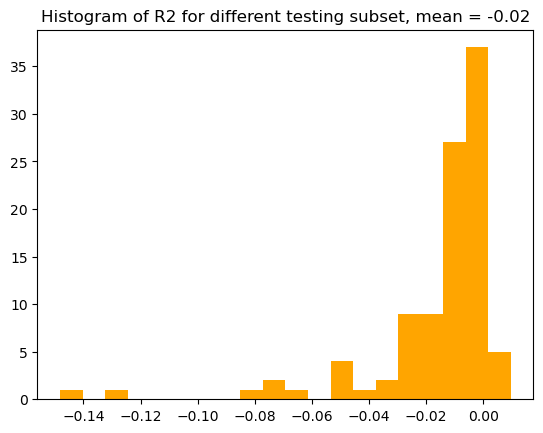

In [9]:
best_param = {'kernel': [model.best_params['kernel']]}
res = []
for i in range(nb_rep):
    X_train, X_test, y_train, y_test = split_and_flatten(X, y, ratio = 0.2, flatten = flatten)

    scaler = MaxAbsScaler()
    X_train_norm = scaler.fit_transform(X_train)
    X_test_norm = scaler.transform(X_test)

    eva_model = BayersianModels(model_type ='gp', params= best_param)
    eva_model.train(X_train_norm, y_train, verbose = False)
    y_pred, std_pred = eva_model.predict(X_test_norm)
    res.append(r2_score(y_test, y_pred))

plt.hist(res, bins = 20, color='orange')
plt.title(f'Histogram of R2 for different testing subset, mean = {np.mean(res):.2f}', size = 12)

## Active Learning

- From condition lists, generated randomly "nb_new_data_predict" new experiments
- Used trained model above to predict yields from these new experiments
- Using 3 search stategy/acquisation functions (ucb, pi, ei) to calculate usefulness of each of these experiment (or increase model performance or has high yield)
- Select top "nb_new_data" new experiments which are the most benefit to test in lab
- Also print out highest yield predicted through model in selected points

In [10]:
X_new= sampling_without_repeat(sampling_condition, nb_sample = nb_new_data_predict, exited_data=X_train, seed = seed)
X_new_norm = scaler.transform(X_new)
y_pred, std_pred = model.predict(X_new_norm)

ucb = y_pred + theta*std_pred
pi = probability_of_improvement(y_pred, std_pred, max(y_train))
ei = expected_improvement(y_pred, std_pred, max(y_train))

print("For UCB:")
ucb_top, y_ucb, ratio_ucb = find_top_element(X_new, y_pred,ucb, nb_new_data, return_ratio= True)

print("For PI:")
pi_top, y_pi, ratio_pi = find_top_element(X_new, y_pred, pi, nb_new_data, return_ratio= True)

print("For EI:")
ei_top, y_ei, ratio_ei = find_top_element(X_new, y_pred, ei, nb_new_data, return_ratio= True)

For UCB:
Maximum yield prediction = 3.9891334465518824
For PI:
Maximum yield prediction = 3.9891334465518824
For EI:
Maximum yield prediction = 3.9891334465518824


### Explain graphs
- Plot histogram of yield/std: compare between all new experiments and already done experiments. Use to find if there's possible points to increase yield or calculated suitable theta to balance explore/exploit when using ucb
- Plot scatter compare yield and std of selected points with not selected points
- Plot eculide distance from each point to the first/most benefit point, this make sure new selected points arn't clusted (distance too close to first point) and benefit enough (has acquisation value significantly diffent from unslected points)

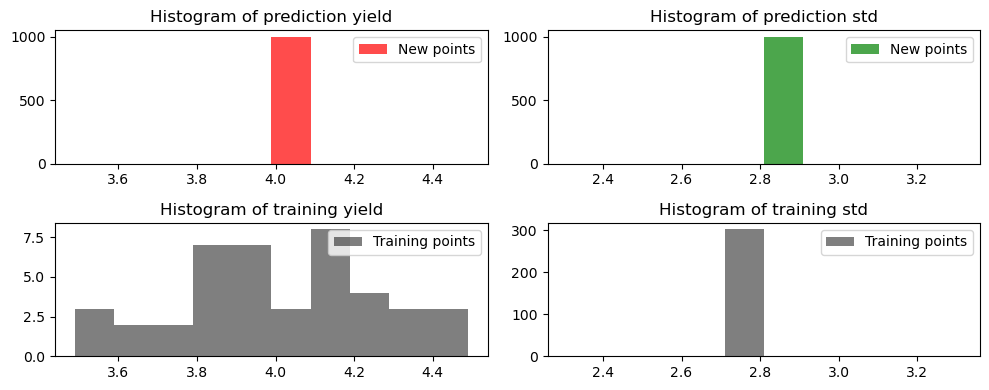

In [11]:
plot_hist_yield_std(y_pred, y_train, std_pred, std_pred_train)

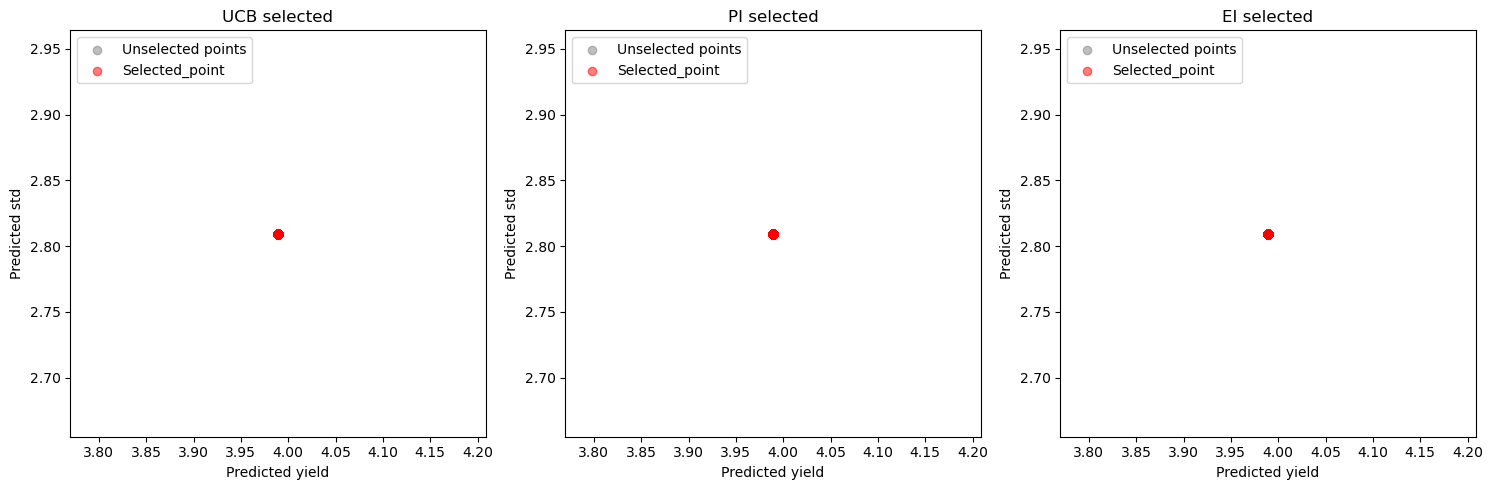

In [12]:
# Set up the figure with three subplots in a single row
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # Adjust the figsize as needed

plot_selected_point(axes[0], y_pred, std_pred, y_ucb, 'UCB selected')
plot_selected_point(axes[1], y_pred, std_pred, y_pi, 'PI selected')
plot_selected_point(axes[2], y_pred, std_pred, y_ei, 'EI selected')
# Adjust layout to prevent clipping of titles
plt.tight_layout()

# Show the plots
plt.show()

#plot_hist_selected_yield(y_pred, y_ucb, title = 'UCB selected new data prediction yield')

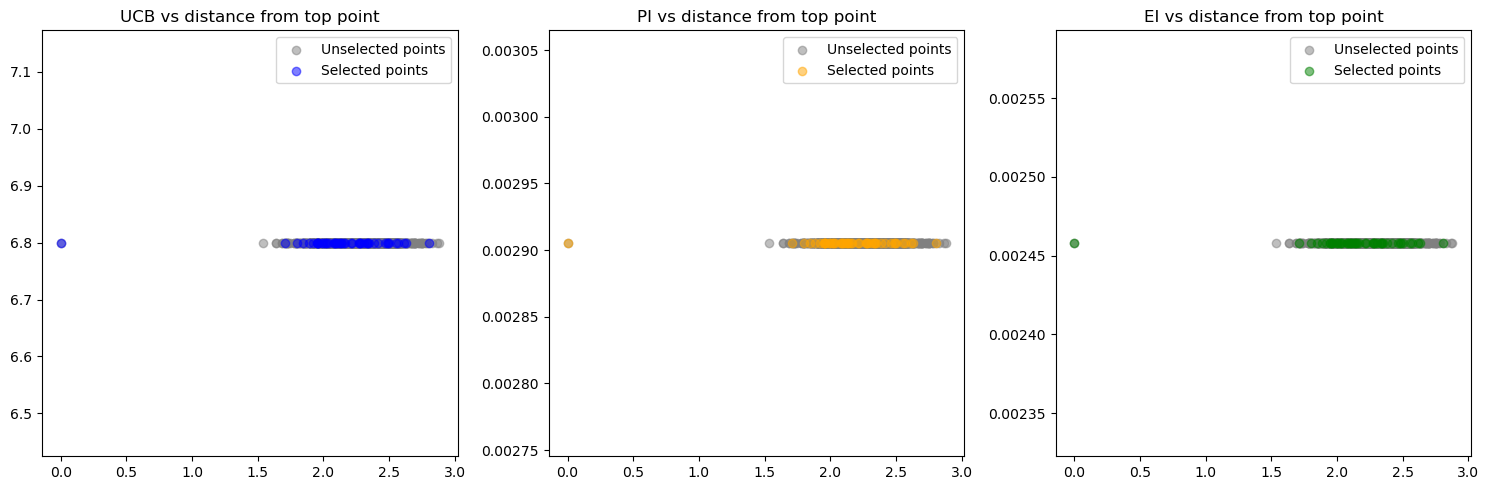

In [13]:
ucb_top_norm = scaler.transform(ucb_top)
pi_top_norm = scaler.transform(pi_top)
ei_top_norm = scaler.transform(ei_top)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
plot_distance(axes[0], X_new_norm,ucb_top_norm, ucb, ratio_ucb, 'blue', 'UCB vs distance from top point')
plot_distance(axes[1], X_new_norm,pi_top_norm, pi, ratio_pi, 'orange', 'PI vs distance from top point')
plot_distance(axes[2], X_new_norm,ei_top_norm, ei, ratio_ei, 'green', 'EI vs distance from top point')

plt.tight_layout()
plt.show()

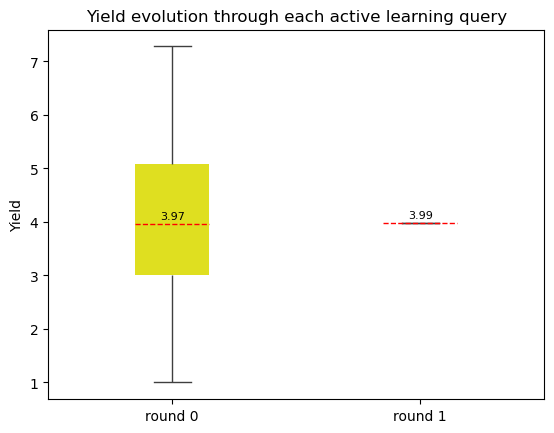

In [14]:
acq = {'ucb': y_ucb, 'pi': y_pi, 'ei': y_ei}
size_list.append(nb_new_data)
y_mean = np.append(y_mean, acq[statergy])
plot_each_round(y_mean,size_list, predict = True)

## Model interprétation

- Plot heatmap of all generated experiments with its yield from low to high, color represent substance concentrations, use to look for each factor-X influence on yield-y
- Similar plot but zoom on top selected points

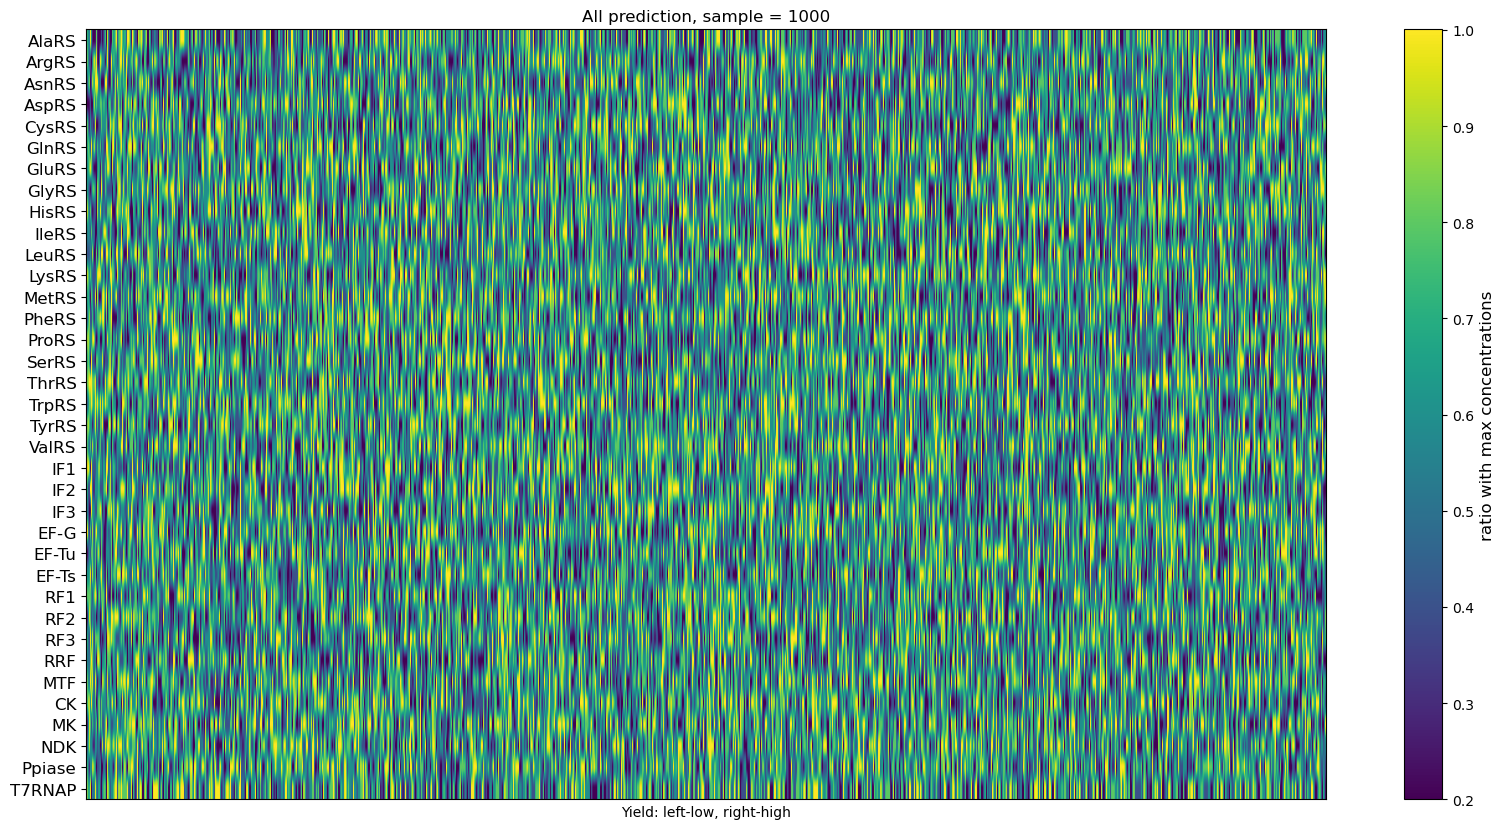

In [17]:
fig, axes = plt.subplots(1, 1, figsize=(20, 10))
plot_heatmap(axes, X_new_norm, y_pred, element_list, 'All prediction')
plt.xlabel("Yield: left-low, right-high")
plt.show()

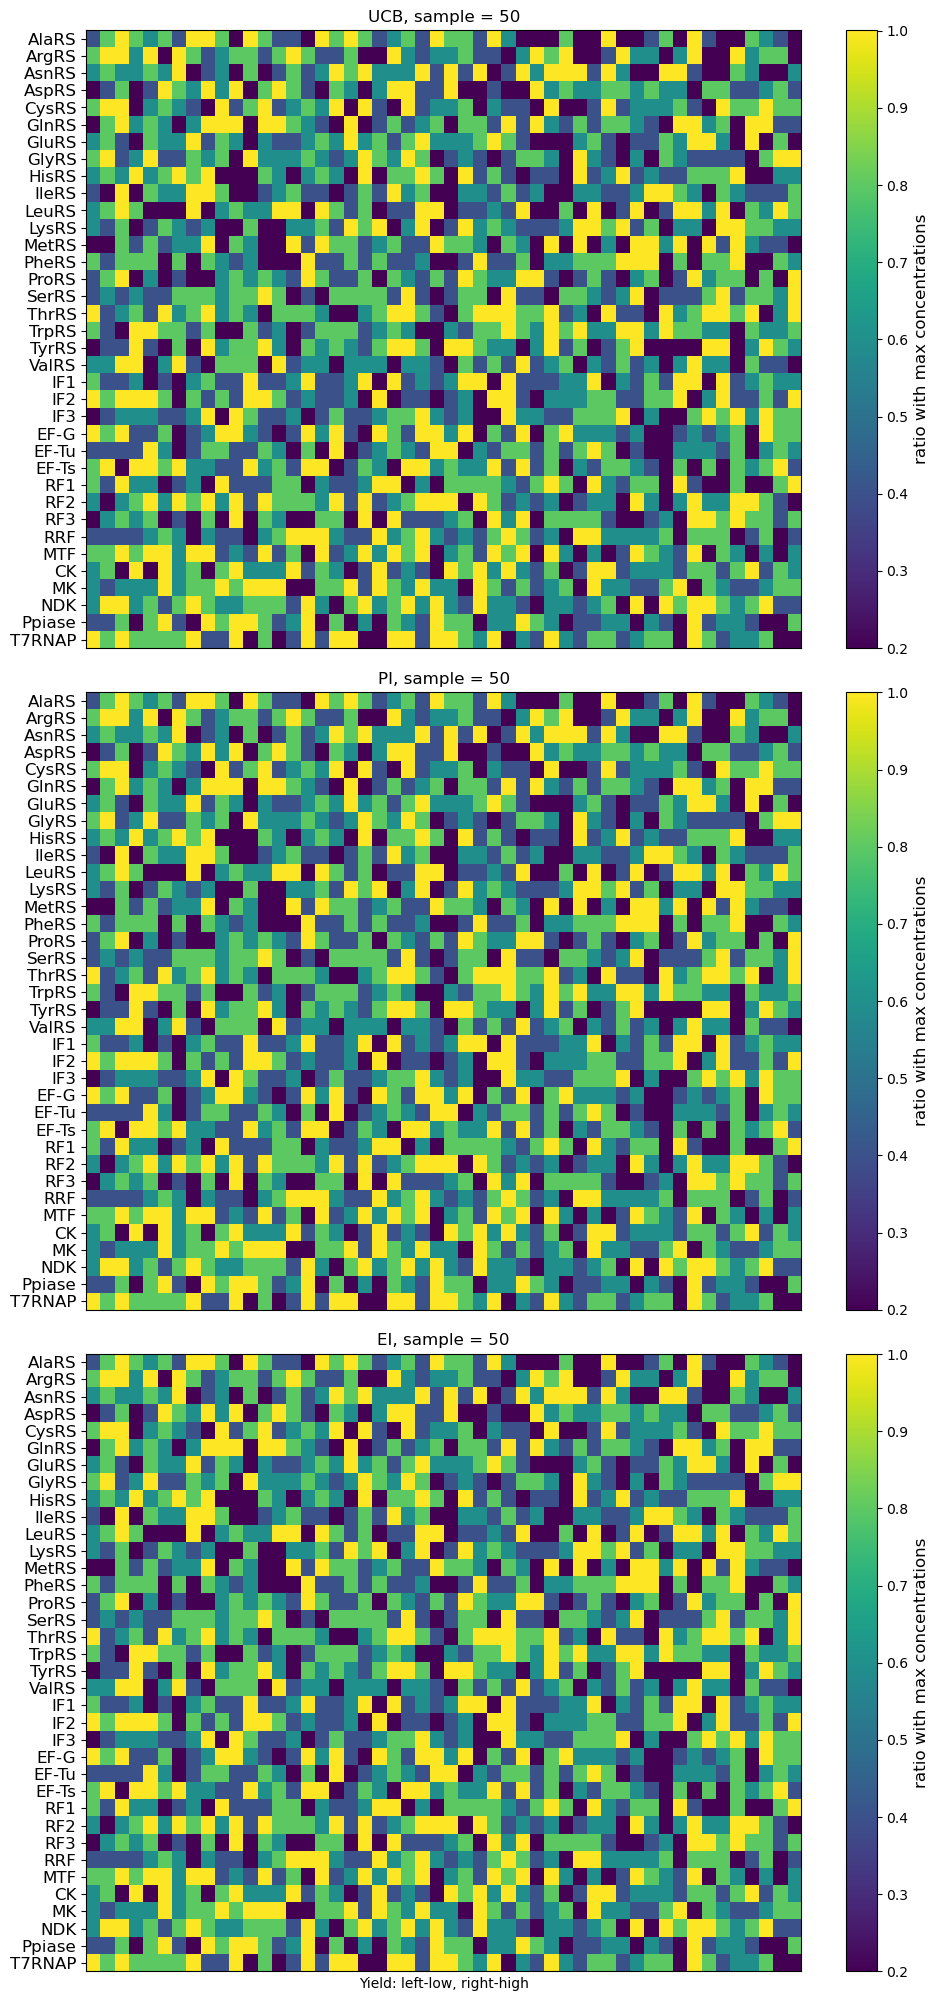

In [19]:
fig, axes = plt.subplots(3, 1, figsize=(10, 20))
plot_heatmap(axes[0], ucb_top_norm, y_ucb, element_list, 'UCB')
plot_heatmap(axes[1], pi_top_norm, y_pi, element_list, 'PI')
plot_heatmap(axes[2], ei_top_norm, y_ei, element_list, 'EI')
plt.tight_layout()
plt.xlabel("Yield: left-low, right-high")
plt.show()

## Saving result

In [ ]:
X_pi = pd.DataFrame(pi_top, columns=element_list)
name = save_name + '_pi.csv'
X_pi.to_csv(name, index=False)

X_ei = pd.DataFrame(ei_top, columns=element_list)
name = save_name + '_ei.csv'
X_ei.to_csv(name, index=False)

X_ucb = pd.DataFrame(ucb_top, columns=element_list)
name = save_name + '_ucb.csv'
X_ucb.to_csv(name, index=False)

In [ ]:
data_new = pd.DataFrame(X_new, columns=element_list)
data_new.loc[:,'predict_yield'] = y_pred
data_new.loc[:,'pi'] = pi
data_new.loc[:,'ei'] = ei
data_new.loc[:,'ucb'] = ucb
data_new = pd.merge(X_ucb, data_new, on=element_list, how='left')
name = save_name + '_combine.csv'
data_new.to_csv(name, index=False)